In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np









In [2]:
## Machine learning Superrvised regression example
# Load data
df = pd.read_csv("C:\\Users\\93810\\Downloads\\regression test.csv")
df.head()

,Dispatch Date,Region,District Name,Customer Name,DOCs Ordered,DOCs Received,DOC Dead Upon Arrival,DOC Dead 1st Week,first_week_mortality,hatchery,hatcher,setter,DriverName,VehicleNumber,source_of_eggs,CustomerType,Dispatch Duration,Vaccinator
0,4-Aug-25,East,Jinja,Gorreti Nagayi,153,117,33.0,40.0,0.34,Kawempe,H9,M4,MED SEBUNYA,UBE 722B,Buruli,New,NaN,NaN
1,8-Aug-25,North,Gulu,ABER BARBRA,102,102,NaN,16.0,0.16,Kawempe,H5,M16,GALIWANGO IBRAHIM,UBQ 616C,Buruli,Existing,NaN,NaN
2,4-Aug-25,East,Buyende,MAIRI JOHN,408,408,NaN,45.0,0.11,Kawempe,H7,M2,ATUJUNE PIRASON,UBN 157N,Buruli,Existing,NaN,NaN
3,4-Aug-25,East,Iganga,NABULUMBA MADINA BALIKOWA,510,510,NaN,50.0,0.10,Kawempe,H9,M4,MED SEBUNYA,UBE 722B,Buruli,Existing,NaN,NaN
4,8-Aug-25,North East,Lira,Okello Aron,153,153,NaN,15.0,0.10,Kawempe,H5,M16,GALIWANGO IBRAHIM,UBQ 616C,Buruli,Existing,NaN,NaN


In [3]:
# Define dependent and independent variables
y_col = "first_week_mortality"
x_cols = ["hatchery", "hatcher", "setter", "DriverName", 
          "VehicleNumber", "source_of_eggs", "CustomerType"]

# Check for NaNs
print("NaNs in y:", df[y_col].isna().sum())
print("NaNs in X columns:\n", df[x_cols].isna().sum())

# Handle NaNs in y: Drop rows where y is NaN
df = df.dropna(subset=[y_col])
print(f"Data shape after dropping NaN y rows: {df.shape}")

# Handle NaNs in X: Fill categorical NaNs with 'Unknown' (or use df.dropna(subset=x_cols) to drop)
df[x_cols] = df[x_cols].fillna('Unknown')

# Separate features (X) and target (y)
X = df[x_cols]
y = df[y_col]

NaNs in y: 85
NaNs in X columns:
 hatchery          85
hatcher           85
setter            85
DriverName        85
VehicleNumber     85
source_of_eggs    85
CustomerType      85
dtype: int64
Data shape after dropping NaN y rows: (492, 18)


In [4]:
# Create a preprocessor to handle categorical variables using OneHotEncoder
# All x_cols are categorical, so we apply OneHotEncoder to all of them
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), x_cols)
    ])

# Create a pipeline that combines preprocessing and the linear regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Print R-squared score for model performance
print("Training R-squared:", pipeline.score(X_train, y_train))
print("Testing R-squared:", pipeline.score(X_test, y_test))

Training R-squared: 0.1588575740007555
Testing R-squared: -0.02259461738509594


In [8]:
# For detailed statistical analysis (p-values, coefficients, etc.), use statsmodels
# Transform the features using the preprocessor (fits on full X for statsmodels)
X_transformed = preprocessor.fit_transform(X)

# DEBUG: Print type and shape before conversion
print("Type of X_transformed:", type(X_transformed))
print("Shape of X_transformed before densify:", X_transformed.shape)

# Convert to dense if sparse
if hasattr(X_transformed, 'toarray'):
    X_transformed = X_transformed.toarray()
    print("Shape after toarray():", X_transformed.shape)

# Get feature names after encoding
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(x_cols)
print(f"Number of feature names: {len(feature_names)}")  # Should match new shape[1]

# Convert to DataFrame for statsmodels
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Add constant for intercept
X_transformed_df = sm.add_constant(X_transformed_df)

# Fit the model using statsmodels
model = sm.OLS(y, X_transformed_df).fit()

# Print the summary
#print(model.summary())
print(model.params.sort_values(key=abs, ascending=False))

Type of X_transformed: <class 'scipy.sparse._csr.csr_matrix'>
Shape of X_transformed before densify: (492, 52)
Shape after toarray(): (492, 52)
Number of feature names: 52
setter_M16                       0.016683
DriverName_LUTAAYA ALI          -0.015362
DriverName_MED SEBUNYA           0.014595
DriverName_NGIM DENISH           0.012692
setter_M12                      -0.011770
DriverName_MUBIRU JOEL           0.011302
DriverName_EDWARD KYAMBBADE     -0.010478
const                            0.010344
hatcher_H5                       0.010176
setter_M18                       0.008176
VehicleNumber_UBQ 615C          -0.007186
VehicleNumber_UBM 460W           0.006920
hatcher_H7                      -0.006674
setter_M5                       -0.006507
DriverName_ARIHO DAVIS          -0.005772
DriverName_ATUJUNE PIRASON       0.005672
VehicleNumber_UBN 159N           0.005558
DriverName_OKETCH GEORGE        -0.005485
VehicleNumber_UBN 157N           0.005384
VehicleNumber_UBN 257N        

R-squared: 0.096—Only 9.6% of variation in mortality is explained by the independent variables. 

Adj. R-squared: 0.037—Even lower (3.7%) after penalizing for 30+ variables; indicates the model isn't worth the complexity—many variables add noise.

F-statistic: 1.628, Prob (F-statistic): 0.028—Overall model is significant (p<0.05), so the independent variables collectively matter (not pure chance), but weakly.

C:\Users\93810\AppData\Local\Temp\ipykernel_74492\308588710.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top_abs = sig_abs[sorted_idx]
C:\Users\93810\AppData\Local\Temp\ipykernel_74492\308588710.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top_coefs = sig_coefs[sorted_idx]  # For colors: positive red, negative blue
C:\Users\93810\AppData\Local\Temp\ipykernel_74492\308588710.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

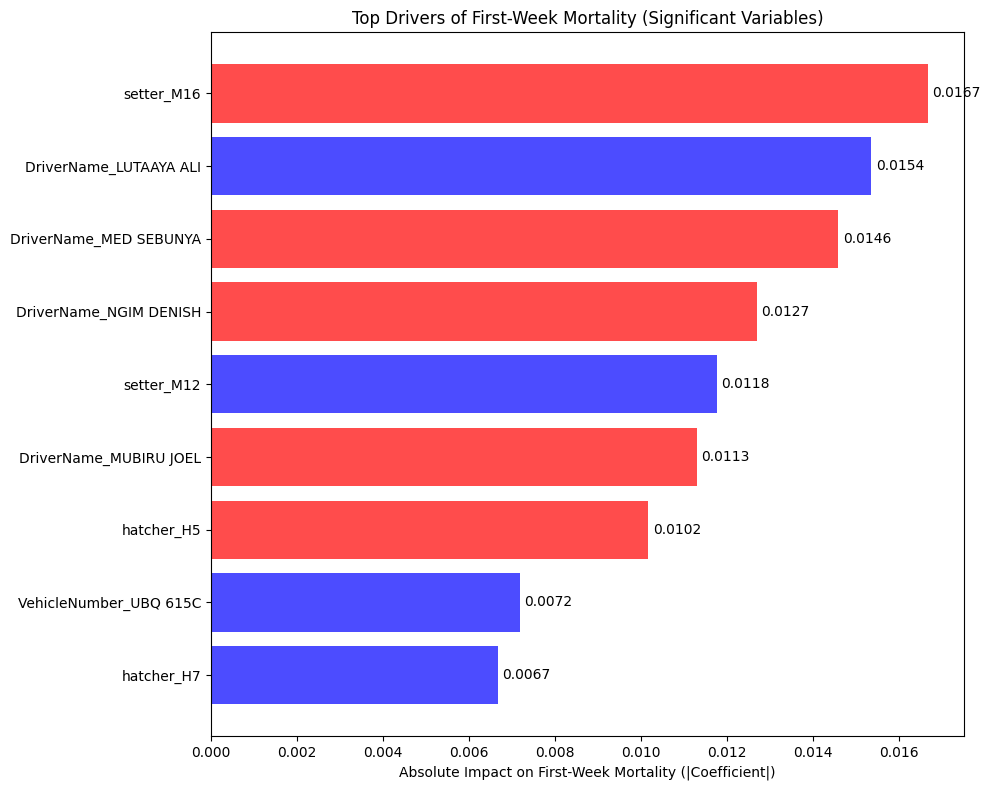

In [10]:


# Extract coefficients and p-values (after model.fit())
coefs = model.params[1:]  # Skip const
pvals = model.pvalues[1:]
std_errs = model.bse[1:]

# Filter significant (p<0.05) and sort by abs(coef)
sig_mask = pvals < 0.05
sig_coefs = coefs[sig_mask]
sig_names = model.params.index[1:][sig_mask]  # Feature names
sig_abs = np.abs(sig_coefs)
sorted_idx = np.argsort(sig_abs)[::-1][:15]  # Top 15

top_names = sig_names[sorted_idx]
top_abs = sig_abs[sorted_idx]
top_coefs = sig_coefs[sorted_idx]  # For colors: positive red, negative blue

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['red' if c > 0 else 'blue' for c in top_coefs]
bars = ax.barh(top_names, top_abs, color=colors, alpha=0.7)
ax.set_xlabel('Absolute Impact on First-Week Mortality (|Coefficient|)')
ax.set_title('Top Drivers of First-Week Mortality (Significant Variables)')
ax.invert_yaxis()  # Largest on top

# Add value labels
for i, bar in enumerate(bars):
    ax.text(bar.get_width() + 0.0001, bar.get_y() + bar.get_height()/2, f'{top_abs[i]:.4f}', va='center')

plt.tight_layout()
plt.savefig('mortality_impact_chart.png', dpi=300)  # Export for email
plt.show()